In [1]:
import pandas as pd 
import json
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 
import random
ip = str(json.load(open('/home/onos/Downloads/flask_SDN/config.json'))['ip_local'])
file_name = str(ip).split('.')[-1] + '_lstm'

dataframe = pd.read_csv('/home/onos/Downloads/' + file_name + '.csv')
dataframe

2022-08-15 16:09:15.173634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 16:09:15.173663: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


,Unnamed: 0,IpSDN,src,dst,byteReceived,byteSent,delay,linkUtilization,overhead,packetLoss,ratio_overhead,label
0,0,10.20.0.200,of:0000000000000006,of:0000000000000007,4.274906,10.506868,332,0.000000,7.390887,0.000000,0.000000,0
1,1,10.20.0.200,of:000000000000002c,of:000000000000002d,8.412595,0.000280,856,0.336515,4.206437,0.000000,0.000000,0
2,2,10.20.0.200,of:000000000000002c,of:000000000000002d,8.412595,0.000280,856,0.336515,4.206437,0.000000,0.000000,0
3,3,10.20.0.200,of:000000000000003d,of:000000000000003f,18.924586,18.923776,484,1.000000,18.924181,0.000000,0.000000,0
4,4,10.20.0.200,of:0000000000000005,of:0000000000000004,8.413157,0.000278,27,0.000000,4.206717,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
144162,144162,10.20.0.200,of:0000000000000001,of:0000000000000002,0.090584,31.445310,83,1.000000,15.767947,0.999988,89.102556,0
144163,144163,10.20.0.200,of:0000000000000004,of:000000000000003c,4.365061,4.363172,82,0.562064,4.364116,0.000000,23.937809,1
144164,144164,10.20.0.200,of:0000000000000002,of:0000000000000001,120.217520,2.000688,76,0.951297,61.109104,0.000000,348.194880,0
144165,144165,10.20.0.200,of:0000000000000005,of:0000000000000004,2.361479,2.360848,65,0.014010,2.361163,0.000000,12.492363,0


In [2]:
dataframe.drop(['Unnamed: 0', 'label'] , axis=1, inplace=True)

In [3]:
def _nor_with_min(x, min, max):
    return (max - x) / (max - min)
def _nor_with_max(x, min, max):
    return (x - min) / (max - min)
def get_label(_d, _l, _p, _o, _a1, _a2, _a3, _a4):
    return _d*_a1 + _l*_a2 + _p*_a3 + _o*_a4

In [4]:
link_costs = get_label(_nor_with_max(dataframe['delay'].values, min(dataframe['delay'].values), max(dataframe['delay'].values)), 
                        dataframe['linkUtilization'].values,
                        dataframe['packetLoss'],
                        _nor_with_max(dataframe['overhead'], min(dataframe['overhead'].values), max(dataframe['overhead'].values)),
0.25, 0.25, 0.25, 0.25) 

In [5]:
dataframe['link_costs'] = link_costs

In [6]:
dataframe

,IpSDN,src,dst,byteReceived,byteSent,delay,linkUtilization,overhead,packetLoss,ratio_overhead,link_costs
0,10.20.0.200,of:0000000000000006,of:0000000000000007,4.274906,10.506868,332,0.000000,7.390887,0.000000,0.000000,0.103671
1,10.20.0.200,of:000000000000002c,of:000000000000002d,8.412595,0.000280,856,0.336515,4.206437,0.000000,0.000000,0.302295
2,10.20.0.200,of:000000000000002c,of:000000000000002d,8.412595,0.000280,856,0.336515,4.206437,0.000000,0.000000,0.302295
3,10.20.0.200,of:000000000000003d,of:000000000000003f,18.924586,18.923776,484,1.000000,18.924181,0.000000,0.000000,0.428443
4,10.20.0.200,of:0000000000000005,of:0000000000000004,8.413157,0.000278,27,0.000000,4.206717,0.000000,0.000000,0.020220
...,...,...,...,...,...,...,...,...,...,...,...
144162,10.20.0.200,of:0000000000000001,of:0000000000000002,0.090584,31.445310,83,1.000000,15.767947,0.999988,89.102556,0.572160
144163,10.20.0.200,of:0000000000000004,of:000000000000003c,4.365061,4.363172,82,0.562064,4.364116,0.000000,23.937809,0.174394
144164,10.20.0.200,of:0000000000000002,of:0000000000000001,120.217520,2.000688,76,0.951297,61.109104,0.000000,348.194880,0.459585
144165,10.20.0.200,of:0000000000000005,of:0000000000000004,2.361479,2.360848,65,0.014010,2.361163,0.000000,12.492363,0.026639


In [7]:
dataframe.drop(['IpSDN', 'src', 'dst', 'byteReceived', 'byteSent', 'ratio_overhead'], axis=1, inplace=True)

In [8]:
dataframe

,delay,linkUtilization,overhead,packetLoss,link_costs
0,332,0.000000,7.390887,0.000000,0.103671
1,856,0.336515,4.206437,0.000000,0.302295
2,856,0.336515,4.206437,0.000000,0.302295
3,484,1.000000,18.924181,0.000000,0.428443
4,27,0.000000,4.206717,0.000000,0.020220
...,...,...,...,...,...
144162,83,1.000000,15.767947,0.999988,0.572160
144163,82,0.562064,4.364116,0.000000,0.174394
144164,76,0.951297,61.109104,0.000000,0.459585
144165,65,0.014010,2.361163,0.000000,0.026639


In [9]:
y = dataframe['link_costs']
X = dataframe.drop(columns='link_costs')
y_set = y.values
X_set = X.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_set = scaler.fit_transform(X_set)

In [11]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_X, test_X, train_y, test_y = train_test_split(X_set, y_set, test_size = 0.3)
val_X,test_X, val_y,test_y = train_test_split(test_X, test_y, test_size=0.3)
# Thay đổi shape của tập X
time_steps = 1
input_train_lstm = train_X.reshape( train_X.shape[0], time_steps, train_X.shape[1] )
input_val_lstm = val_X.reshape( val_X.shape[0], time_steps, val_X.shape[1])
input_test_lstm = test_X.reshape( test_X.shape[0], time_steps, test_X.shape[1])


In [12]:
# #Building the LSTM Model
lstm = Sequential()
# unit = hidden state
lstm.add(LSTM(units=64, input_shape=(time_steps, input_train_lstm.shape[2]), activation='relu', return_sequences=True))

lstm.add(LSTM(units=128, activation='relu', return_sequences=True))

lstm.add(LSTM(units=64, activation='relu', return_sequences=False))


# lop dau vao hinh tron
lstm.add(Dense(1)) 

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
mape = tf.keras.losses.MeanAbsolutePercentageError()
lstm.compile(loss='mean_squared_error', optimizer=opt)
lstm.summary()
file_name = "/home/onos/Downloads/flask_SDN/lstmlocal_new.hdf5"
checkpoint = ModelCheckpoint(file_name, monitor='mean_squared_error', save_best_only=True, mode='auto', period=1, verbose=1)
# early = EarlyStopping(monitor='accuracy')
epoch=200

from time import time
start = time()

history = lstm.fit(input_train_lstm,
                   train_y,
                   epochs=epoch,
                   verbose=1,
                   callbacks=[checkpoint])
                   
print('Total training time: ', time()-start)

2022-08-15 16:13:04.283565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-15 16:13:04.283596: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-15 16:13:04.283614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onos-virtual-machine): /proc/driver/nvidia/version does not exist
2022-08-15 16:13:04.284346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             17664     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 165,953
Trainable params: 165,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
3154/3154 [==============================] - 16s 4ms/step - loss: 0.0014
Epoch 2/200
3154/3154 [==============================] - 13s 4ms/step - loss: 8.5402e-07
Epoch 3/

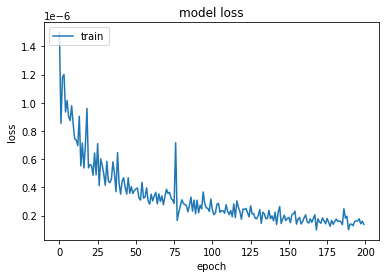

In [20]:
import matplotlib.pyplot as plt
plt.plot([0.0000015] + history.history['loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('line_plot.pdf')

In [21]:
history.history['loss'][1:]

[8.540201861251262e-07,
 1.1818134453278617e-06,
 1.200571091430902e-06,
 9.34981869704643e-07,
 1.0167216260015266e-06,
 9.024780638355878e-07,
 8.742575801079511e-07,
 9.788034276425606e-07,
 8.480308792968572e-07,
 7.431102062582795e-07,
 7.362628480223066e-07,
 6.968506909288408e-07,
 9.042429383043782e-07,
 5.532532441065996e-07,
 7.151363661250798e-07,
 5.379627054935554e-07,
 7.014766651991522e-07,
 9.597977168596117e-07,
 5.384633823268814e-07,
 5.625319658975059e-07,
 5.539593530556886e-07,
 4.869075951319246e-07,
 6.44543888483895e-07,
 4.892327183370071e-07,
 7.103333814484358e-07,
 4.1302754993921553e-07,
 6.029098358339979e-07,
 5.575339514507505e-07,
 4.94356299896026e-07,
 4.145637717556383e-07,
 5.850445177202346e-07,
 4.4495794782051235e-07,
 4.333667504852201e-07,
 4.5867187736803317e-07,
 5.818058070872212e-07,
 4.976363925379701e-07,
 3.6977647255298507e-07,
 6.477305305452319e-07,
 4.3074626887573686e-07,
 3.5196541148252436e-07,
 4.436939775587234e-07,
 4.68731457